# DenseNet Freezing Layers Experiments and Final Training

## PRE-PROCESSING

In [1]:
RUN_MODE = "experiment"

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Absolute root where train/val/test exist after unzipping
DATA_ROOT = r'/kaggle/input/dataset-finals/final_dementia_split'

# Robust per-image normalization
def robust_normalize(image):
    image = image.astype(np.float32) / 255.0
    mask = image > 0
    pixels = image[mask]
    if pixels.size > 0:
        median = np.median(pixels)
        q25, q75 = np.percentile(pixels, [25, 75])
        iqr = q75 - q25
        if iqr > 0:
            image = (image - median) / iqr
    return image

# Data generators
def create_data_generators(batch_size=32):
    common_datagen = ImageDataGenerator(preprocessing_function=robust_normalize)

    train_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'train'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'validation'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

print('setup data pipeline successfully.')

2026-02-01 11:01:01.081019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769943661.546145      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769943661.711283      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769943662.926760      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943662.926798      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943662.926801      24 computation_placer.cc:177] computation placer alr

setup data pipeline successfully.


In [3]:
#from data_pipeline_setup import create_data_generators
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup distributed training
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPUs: 2
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1769943686.328846      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769943686.334949      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## CONFIGURATION

In [4]:
class Config:
    """Experiment configuration for DenseNet121"""
    # Data
    BATCH_SIZE = 32
    IMG_SIZE = (224, 224)
    NUM_CLASSES = 4
    CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

    # Training
    EPOCHS = 5
    LEARNING_RATE = None #will be set later

    # Paths
    RESULTS_DIR = '/kaggle/working/results/densenet/'
    MODELS_DIR = '/kaggle/working/models/densenet/'

    # Freezing configurations (absolute layer counts) - WILL BE SET MANUALLY AFTER LAYER EXPLORATION
    FREEZE_CONFIGS = [
        {'name': 'freeze_all', 'layers': 462},
        {'name': 'freeze_conv4', 'layers': 312},
        {'name': 'freeze_conv3', 'layers': 140},
        {'name': 'freeze_conv2', 'layers': 52},
        {'name': 'freeze_conv1', 'layers': 6},
        {'name': 'freeze_none', 'layers': 0}
    ]

config = Config()

# Create directories
os.makedirs(config.RESULTS_DIR, exist_ok=True)
os.makedirs(config.MODELS_DIR, exist_ok=True)

print('setup  config')

setup  config


## DATA LOADING

In [5]:

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

# Load data using your preprocessing pipeline
# Replace this import with your actual preprocessing module
try:
    train_gen, val_gen, test_gen = create_data_generators(batch_size=config.BATCH_SIZE)
    print(f"✓ Data generators created successfully")
    print(f"  Train batches: {len(train_gen)}")
    print(f"  Val batches: {len(val_gen)}")
    print(f"  Test batches: {len(test_gen)}")
except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("\nPlease ensure:")
    print("1. preprocessing.py exists with create_data_generators() function")
    print("2. Data directories are set up correctly")
    raise

# Test data pipeline
print("\nTesting data pipeline...")
try:
    sample_batch, sample_labels = next(iter(train_gen))
    print(f"✓ Sample batch shape: {sample_batch.shape}")
    print(f"✓ Sample labels shape: {sample_labels.shape}")
    print(f"✓ Image value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
    print(f"✓ Labels (first 5): {sample_labels[:5]}")
except Exception as e:
    print(f"✗ Data pipeline test failed: {e}")
    raise



LOADING DATA
Found 30800 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
✓ Data generators created successfully
  Train batches: 963
  Val batches: 207
  Test batches: 207

Testing data pipeline...
✓ Sample batch shape: (32, 224, 224, 3)
✓ Sample labels shape: (32, 4)
✓ Image value range: [-1.609, 2.087]
✓ Labels (first 5): [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## MODEL ARCHITECTURE EXPLORATION

In [6]:

print("\n" + "="*70)
print("DENSENET121 ARCHITECTURE EXPLORATION")
print("="*70)

# Load base model to explore architecture
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print(f"\nTotal layers in DenseNet121: {len(base_model.layers)}")
print("\nFirst 10 layers:")
for i in range(min(10, len(base_model.layers))):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

print("\nLast 10 layers:")
for i in range(max(0, len(base_model.layers)-10), len(base_model.layers)):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

# Save layer information
layer_info = []
for i, layer in enumerate(base_model.layers):
    layer_info.append({
        'index': i,
        'name': layer.name,
        'type': layer.__class__.__name__,
        'trainable': layer.trainable
    })

df_layers = pd.DataFrame(layer_info)
df_layers.to_csv(f'{config.RESULTS_DIR}/densenet_layers.csv', index=False)
print(f"\n✓ Layer information saved to {config.RESULTS_DIR}/densenet_layers.csv")
print("\n✓ Use the CSV above to identify the exact blocks and layers you want to freeze.")
print("✓ Then manually set FREEZE_CONFIGS with the layer indices.")

print('done')


DENSENET121 ARCHITECTURE EXPLORATION
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Total layers in DenseNet121: 427

First 10 layers:
    0. input_layer                    | InputLayer           | trainable
    1. zero_padding2d                 | ZeroPadding2D        | trainable
    2. conv1_conv                     | Conv2D               | trainable
    3. conv1_bn                       | BatchNormalization   | trainable
    4. conv1_relu                     | Activation           | trainable
    5. zero_padding2d_1               | ZeroPadding2D        | trainable
    6. pool1                          | MaxPooling2D         | trainable
    7. conv2_block1_0_bn              | BatchNormalization   | trainable
    8. conv2_block1_0_relu            | Activation           | trainable
    9. conv2_block1_1_conv            | Conv2D               | trainable

Last 10 layers:
  417. conv5_block15_concat           | Concatenate          | trainable
  418. conv5_block16_0_bn             |

## MODEL CREATION FUNCTIONS

In [7]:
#learning rate when more layers are trainable needs to decrease accordingly
def get_learning_rate_for_config(num_frozen_layers, total_layers=367):
    """Calculate learning rate based on number of trainable layers in DenseNet121"""
    trainable_layers = total_layers - num_frozen_layers
    trainable_ratio = trainable_layers / total_layers
    
    if trainable_ratio < 0.2:
        return 0.001
    elif trainable_ratio < 0.5:
        return 0.0005
    elif trainable_ratio < 0.8:
        return 0.0001
    else:
        return 0.00005

def create_model(num_frozen_layers=0, num_classes=4):
    """Create DenseNet121 model with specified number of frozen layers

        num_frozen_layers: Number of layers to freeze from the beginning (0-367)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze specified number of layers
    for i, layer in enumerate(base_model.layers):
        if i < num_frozen_layers:
            layer.trainable = False
        else:
            layer.trainable = True

    # Count trainable parameters
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    frozen_count = len(base_model.layers) - trainable_count

    # Build complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ], name=f'densenet_freeze_{num_frozen_layers}')

    #set_learning_rate
    lr = get_learning_rate_for_config(num_frozen_layers)
    config.LEARNING_RATE = lr 
        
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nMODEL SUMMARY")
    print("=" * 70)
    model.summary()
    print("=" * 70)

    print(f"DenseNet121 Model Created: Freeze {num_frozen_layers} layers")
    print(f"{'─'*70}")
    print(f"  Total base layers: {len(base_model.layers)}")
    print(f"  Frozen layers: {frozen_count}")
    print(f"  Trainable layers: {trainable_count}")
    print(f"  Trainable params: {model.count_params():,}")

    return model

print('created  model')


created  model


## TRAINING AND EVALUATION FUNCTION

In [8]:
def train_model(model, config_name, train_gen, val_gen, epochs=15):
    """
    Train model with callbacks and save results

    Args:
        model: Compiled Keras model
        config_name: Name of configuration (for saving)
        train_gen: Training data generator
        val_gen: Validation data generator
        epochs: Number of epochs

    Returns:
        history: Training history object
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {config_name}")
    print(f"{'='*70}")

    if RUN_MODE == "experiment":
        config.EPOCHS = 10
        STEPS_PER_EPOCH = 250
        VAL_STEPS = 100
    elif RUN_MODE == "final":
        config.EPOCHS = 50
        STEPS_PER_EPOCH = None
        VAL_STEPS = None
    else:
        raise ValueError("Invalid RUN_MODE")
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            filepath=f'{config.MODELS_DIR}/{config_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train
    start_time = datetime.now()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config.EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = (datetime.now() - start_time).total_seconds() / 60

    print(f"\n✓ Training completed in {training_time:.2f} minutes")

    return history, training_time

def evaluate_model(model, config_name, history, training_time, val_gen):
    """
    Evaluate model and save results

    Args:
        model: Trained model
        config_name: Configuration name
        history: Training history
        training_time: Time taken to train (minutes)
        val_gen: Validation generator

    Returns:
        results: Dictionary of results
    """
    # Get best metrics from history
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    best_train_acc = history.history['accuracy'][best_epoch]
    final_val_loss = history.history['val_loss'][best_epoch]

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)

    results = {
        'config_name': config_name,
        'best_epoch': best_epoch + 1,
        'total_epochs': len(history.history['loss']),
        'best_train_accuracy': best_train_acc,
        'best_val_accuracy': best_val_acc,
        'final_val_loss': final_val_loss,
        'training_time_minutes': training_time
    }

    print(f"\n{'─'*70}")
    print(f"RESULTS: {config_name}")
    print(f"{'─'*70}")
    print(f"  Best Epoch: {results['best_epoch']}/{results['total_epochs']}")
    print(f"  Train Accuracy: {results['best_train_accuracy']:.4f}")
    print(f"  Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"  Val Loss: {results['final_val_loss']:.4f}")
    print(f"  Training Time: {results['training_time_minutes']:.2f} min")

    # Save training curves
    plot_training_curves(history, config_name)

    return results

print('setup training and evaluation')

setup training and evaluation


## VISUALIZATION FUNCTIONS

In [9]:

def plot_training_curves(history, config_name):
    """Plot and save training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{config_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{config_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/{config_name}_curves.png', dpi=150, bbox_inches='tight')
    plt.close()

def plot_comparison(results_df):
    """Plot comparison of all configurations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Sort by frozen layers
    results_df = results_df.sort_values('frozen_layers')

    # Accuracy comparison
    ax = axes[0, 0]
    x = range(len(results_df))
    ax.plot(x, results_df['best_train_accuracy'], marker='o', linewidth=2, markersize=8, label='Train Accuracy')
    ax.plot(x, results_df['best_val_accuracy'], marker='s', linewidth=2, markersize=8, label='Val Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy vs Frozen Layers', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Validation accuracy bar chart
    ax = axes[0, 1]
    bars = ax.bar(x, results_df['best_val_accuracy'], color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    # Highlight best
    best_idx = results_df['best_val_accuracy'].idxmax()
    bars[results_df.index.get_loc(best_idx)].set_color('green')

    # Training time
    ax = axes[1, 0]
    ax.bar(x, results_df['training_time_minutes'], color='coral', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Training Time (minutes)', fontsize=12)
    ax.set_title('Training Time by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Overfitting analysis (train - val accuracy)
    ax = axes[1, 1]
    overfitting = results_df['best_train_accuracy'] - results_df['best_val_accuracy']
    bars = ax.bar(x, overfitting, color='orange', alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='No Overfitting')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Train Acc - Val Acc', fontsize=12)
    ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/comparison_all.png', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"\n✓ Comparison plot saved to {config.RESULTS_DIR}/comparison_all.png")

print('setup viz')

setup viz


## MAIN EXPERIMENT LOOP

In [10]:
def run_all_experiments():
    """Run all layer freezing experiments"""

    print("\n" + "#"*70)
    print("STARTING DENSENET121 LAYER FREEZING EXPERIMENTS")
    print("#"*70)
    print(f"\nTotal configurations to test: {len(config.FREEZE_CONFIGS)}")
    print(f"Expected total time: ~{len(config.FREEZE_CONFIGS) * 1.5:.1f} hours (avg 1.5h per config)")

    all_results = []

    for i, freeze_config in enumerate(config.FREEZE_CONFIGS, 1):
        config_name = freeze_config['name']
        num_frozen = freeze_config['layers']

        print(f"\n{'#'*70}")
        print(f"EXPERIMENT {i}/{len(config.FREEZE_CONFIGS)}: {config_name}")
        print(f"{'#'*70}")

        try:
            # Create model
            model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

            # Train model
            history, training_time = train_model(
                model=model,
                config_name=config_name,
                train_gen=train_gen,
                val_gen=val_gen,
                epochs=config.EPOCHS
            )

            # Evaluate and save results
            results = evaluate_model(
                model=model,
                config_name=config_name,
                history=history,
                training_time=training_time,
                val_gen=val_gen
            )

            # Add frozen layers info
            results['frozen_layers'] = num_frozen
            results['trainable_layers'] = len(base_model.layers) - num_frozen

            all_results.append(results)

            # Save intermediate results
            df_results = pd.DataFrame(all_results)
            df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate.csv', index=False)

            # Clear memory
            del model
            tf.keras.backend.clear_session()

            print(f"\n✓ Experiment {i}/{len(config.FREEZE_CONFIGS)} completed successfully")

        except Exception as e:
            print(f"\n✗ Experiment {config_name} failed: {e}")
            continue

    # Final results
    print("\n" + "#"*70)
    print("ALL EXPERIMENTS COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_final.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Best configuration
    best_config = df_results.iloc[0]
    print("\n" + "="*70)
    print("🏆 BEST CONFIGURATION")
    print("="*70)
    print(f"  Configuration: {best_config['config_name']}")
    print(f"  Frozen Layers: {best_config['frozen_layers']}/{len(base_model.layers)}")
    print(f"  Validation Accuracy: {best_config['best_val_accuracy']:.4f}")
    print(f"  Training Accuracy: {best_config['best_train_accuracy']:.4f}")
    print(f"  Overfitting Gap: {best_config['best_train_accuracy'] - best_config['best_val_accuracy']:.4f}")

    # Create comparison plots
    plot_comparison(df_results)

    # Save configuration
    with open(f'{config.RESULTS_DIR}/experiment_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## MAIN TRAINING FUNCTION

In [11]:
def run_main_training(name, layers_freeze):
    """Run final model training"""

    print("\n" + "#"*70)
    print(f"STARTING DENSENET MODEL TRAINING FREEZING {layers_freeze} layers")
    print("#"*70)
    
    all_results = []

    config_name = name
    num_frozen = layers_freeze

    try:
        # Create model
        model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

        # Train model
        history, training_time = train_model(
            model=model,
            config_name=config_name,
            train_gen=train_gen,
            val_gen=val_gen,
            epochs=config.EPOCHS
        )

        # Evaluate and save results
        results = evaluate_model(
            model=model,
            config_name=config_name,
            history=history,
            training_time=training_time,
            val_gen=val_gen
        )

        # Add frozen layers info
        results['frozen_layers'] = num_frozen
        results['trainable_layers'] = len(base_model.layers) - num_frozen

        all_results.append(results)

        # Save intermediate results
        df_results = pd.DataFrame(all_results)
        df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate_main.csv', index=False)

        # Clear memory
        del model
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"\n✗ Experiment {config_name} failed: {e}")

    # Final results
    print("\n" + "#"*70)
    print("TRAINING COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_main_model.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Save configuration
    with open(f'{config.RESULTS_DIR}/main_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## BEST MODEL SELECTION

In [12]:
def select_best_model(results_df):
    """
    Intelligent model selection based on:
    1) Peak validation accuracy
    2) Elite group within 0.5% of peak
    3) Generalization gap (Train Acc - Val Acc)
    4) Winner: smallest gap
    5) Tiebreaker: lowest validation loss
    
    Args:
        df_results: DataFrame with experiment results containing columns:
                    - best_val_accuracy
                    - best_train_accuracy
                    - final_val_loss
                    - config_name
                    - frozen_layers
    
    Returns:
        dict: Selected model info with keys:
              - config_name, frozen_layers, best_val_accuracy, best_train_accuracy,
                final_val_loss, generalization_gap, selection_reason
    """
    
    # 1. Peak validation accuracy
    peak_val_acc = results_df['best_val_accuracy'].max()
    peak_val_loss = results_df.loc[results_df['best_val_accuracy'].idxmax(), 'final_val_loss']
    
    print("\n" + "="*70)
    print("MODEL SELECTION ALGORITHM")
    print("="*70)
    print(f"\n1. Peak Validation Accuracy: {peak_val_acc:.4f}")
    
    # 2. Define elite group (within 0.5% of peak)
    threshold = peak_val_acc * 0.995  # 0.5% tolerance
    elite_group = results_df[results_df['best_val_accuracy'] >= threshold].copy()
    
    print(f"\n2. Elite Group Threshold: {threshold:.4f}")
    print(f"   Models in elite group: {len(elite_group)}")
    for idx, row in elite_group.iterrows():
        gap = row['best_train_accuracy'] - row['best_val_accuracy']
        print(f"      - {row['config_name']:20s} | Val Acc: {row['best_val_accuracy']:.4f} | Gap: {gap:+.4f} | Val Loss: {row['final_val_loss']:.4f}")
    
    # 3. Calculate generalization gap for elite group
    elite_group['generalization_gap'] = elite_group['best_train_accuracy'] - elite_group['best_val_accuracy']
    elite_group['abs_gap'] = abs(elite_group['generalization_gap'])
    
    print(f"\n3. Generalization Gap Analysis (Train Acc - Val Acc):")
    for idx, row in elite_group.iterrows():
        print(f"   {row['config_name']:20s} : {row['generalization_gap']:+.4f} (abs: {row['abs_gap']:.4f})")

    # 4. Select winner: smallest absolute gap (closest to zero)
    winner_idx = elite_group['abs_gap'].idxmin()
    winner = elite_group.loc[winner_idx]
    
    selection_reason = f"Smallest abs gap ({winner['generalization_gap']:+.4f})"
    
    # 5. Tiebreaker: if multiple models with same gap, pick lowest val loss
    same_gap = elite_group[elite_group['abs_gap'] == elite_group['abs_gap'].min()]
    if len(same_gap) > 1:
        winner_idx = same_gap['final_val_loss'].idxmin()
        winner = elite_group.loc[winner_idx]
        selection_reason += f", tied → lowest val loss ({winner['final_val_loss']:.4f})"
    
    print("\n" + "="*70)
    print("SELECTED MODEL FOR FINAL TRAINING")
    print("="*70)
    print(f"  Configuration: {winner['config_name']}")
    print(f"  Frozen Layers: {winner['frozen_layers']}")
    print(f"  Val Accuracy: {winner['best_val_accuracy']:.4f}")
    print(f"  Train Accuracy: {winner['best_train_accuracy']:.4f}")
    print(f"  Generalization Gap: {winner['generalization_gap']:.4f}")
    print(f"  Val Loss: {winner['final_val_loss']:.4f}")
    print(f"  Selection Reason: {selection_reason}")
    print("="*70 + "\n")
    
    return {
        'config_name': winner['config_name'],
        'frozen_layers': int(winner['frozen_layers']),
        'best_val_accuracy': winner['best_val_accuracy'],
        'best_train_accuracy': winner['best_train_accuracy'],
        'final_val_loss': winner['final_val_loss'],
        'generalization_gap': winner['generalization_gap'],
        'selection_reason': selection_reason
    }

print('setup model selection function')

setup model selection function


## QUICK TEST FUNCTION

In [13]:

def test_pipeline():
    """Quick test to verify everything works before running full experiments"""
    print("\n" + "="*70)
    print("RUNNING PIPELINE TEST")
    print("="*70)

    try:
        # Test data loading
        print("\n1. Testing data loading...")
        batch, labels = next(iter(train_gen))
        print(f"   ✓ Data batch loaded: {batch.shape}")

        # Test model creation
        print("\n2. Testing model creation...")
        test_model = create_model(num_frozen_layers=100)
        print(f"   ✓ Model created successfully")

        # Test single epoch
        print("\n3. Testing single training epoch...")
        history = test_model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=1)
        print(f"   ✓ Training epoch completed")
        print(f"   Train accuracy: {history.history['accuracy'][0]:.4f}")
        print(f"   Val accuracy: {history.history['val_accuracy'][0]:.4f}")

        print("\n" + "="*70)
        print("✓ PIPELINE TEST PASSED - READY TO RUN FULL EXPERIMENTS")
        print("="*70)

        # Clean up
        del test_model
        tf.keras.backend.clear_session()

        return True

    except Exception as e:
        print(f"\n✗ PIPELINE TEST FAILED: {e}")
        print("\nPlease fix the issue before running full experiments")
        return False

print('setup pipeline')

setup pipeline


## MAIN EXECUTION

In [14]:
# Run experiments
results_df = run_all_experiments()

print("\nEXPERIMENTS COMPLETE!")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


######################################################################
STARTING DENSENET121 LAYER FREEZING EXPERIMENTS
######################################################################

Total configurations to test: 6
Expected total time: ~9.0 hours (avg 1.5h per config)

######################################################################
EXPERIMENT 1/6: freeze_all
######################################################################

MODEL SUMMARY


Model: "densenet_freeze_462"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

DenseNet121 Model Created: Freeze 462 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 427
  Trainable layers: 0
  Trainable params: 7,300,932

TRAINING: freeze_all


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1769943730.787979      67 service.cc:152] XLA service 0x7e850c0034c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769943730.788015      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943730.788019      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943734.223494      67 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:54:12 28s/step - accuracy: 0.2812 - loss: 2.2919

I0000 00:00:1769943746.855519      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.4171 - loss: 1.3548
Epoch 1: val_accuracy improved from -inf to 0.82625, saving model to /kaggle/working/models/densenet//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 573ms/step - accuracy: 0.4174 - loss: 1.3540 - val_accuracy: 0.8263 - val_loss: 0.6137 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5538 - loss: 0.9649
Epoch 2: val_accuracy did not improve from 0.82625
250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 362ms/step - accuracy: 0.5538 - loss: 0.9648 - val_accuracy: 0.6469 - val_loss: 0.7525 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5937 - loss: 0.8833
Epoch 3: val_accuracy did not improve from 0.82625
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.5938 - loss: 0.8832 - val_accuracy: 0.7625 - val_loss: 0.7219 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.6095 - loss: 0.8386

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.82625
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 253ms/step - accuracy: 0.6103 - loss: 0.8377 - val_accuracy: 0.7622 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6393 - loss: 0.7815
Epoch 5: val_accuracy did not improve from 0.82625
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.6393 - loss: 0.7816 - val_accuracy: 0.8225 - val_loss: 0.5476 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6513 - loss: 0.7660
Epoch 6: val_accuracy improved from 0.82625 to 0.83406, saving model to /kaggle/working/models/densenet//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.6513 - loss: 0.7661 - val_accuracy: 0.8341 - val_loss: 0.4968 - learning_rate: 5.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6467 - loss: 0.7653
Epoch 7: val_accuracy improved from 0.83406 to 0.86156, saving model to /kaggle/working/models/densenet//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accuracy: 0.6467 - loss: 0.7653 - val_accuracy: 0.8616 - val_loss: 0.4973 - learning_rate: 5.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.6700 - loss: 0.7434
Epoch 8: val_accuracy did not improve from 0.86156
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 210ms/step - accuracy: 0.6693 - loss: 0.7435 - val_accuracy: 0.8338 - val_loss: 0.4931 - learning_rate: 5.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6553 - loss: 0.7533
Epoch 9: val_accuracy did not improve from 0.86156
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 230ms/step - accuracy: 0.6552 - loss: 0.7533 - val_accuracy: 0.8472 - val_loss: 0.4745 - learning_rate: 5.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6593 - loss: 0.7278
Epoch 10: val_accuracy did not improve from 0.86156
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.6594 - loss: 0.7277 - val_accuracy: 0.7850 - val_loss: 0.5578 - learning_rate: 

Model: "densenet_freeze_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 2,423,556 (9.25 MB)

 Non-trainable params: 4,877,376 (18.61 MB)

DenseNet121 Model Created: Freeze 312 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 312
  Trainable layers: 115
  Trainable params: 7,300,932

TRAINING: freeze_conv4
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5707 - loss: 1.0150
Epoch 1: val_accuracy improved from -inf to 0.94031, saving model to /kaggle/working/models/densenet//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 267ms/step - accuracy: 0.5711 - loss: 1.0141 - val_accuracy: 0.9403 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7323 - loss: 0.6062
Epoch 2: val_accuracy did not improve from 0.94031
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.7324 - loss: 0.6061 - val_accuracy: 0.8512 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7905 - loss: 0.4881
Epoch 3: val_accuracy did not improve from 0.94031
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.7905 - loss: 0.4880 - val_accuracy: 0.9203 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.8233 - loss: 0.4422
Epoch 4: val_accuracy improved from 0.94031 to 0.95781, saving model to /kaggle/working/models/densenet//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.8231 - loss: 0.4409 - val_accuracy: 0.9578 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8523 - loss: 0.3910
Epoch 5: val_accuracy did not improve from 0.95781
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 237ms/step - accuracy: 0.8523 - loss: 0.3909 - val_accuracy: 0.8241 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8775 - loss: 0.3152
Epoch 6: val_accuracy did not improve from 0.95781
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 226ms/step - accuracy: 0.8775 - loss: 0.3151 - val_accuracy: 0.9197 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8920 - loss: 0.2808
Epoch 7: val_accuracy improved from 0.95781 to 0.97812, saving model to /kaggle/working/models/densenet//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.8920 - loss: 0.2808 - val_accuracy: 0.9781 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8956 - loss: 0.2683
Epoch 8: val_accuracy did not improve from 0.97812
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - accuracy: 0.8966 - loss: 0.2656 - val_accuracy: 0.8525 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9153 - loss: 0.2302
Epoch 9: val_accuracy did not improve from 0.97812
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.9153 - loss: 0.2302 - val_accuracy: 0.9534 - val_loss: 0.1384 - learning_rate: 0.0010
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9265 - loss: 0.1950
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_accuracy did not improve from 0.97812
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.9265 - loss: 

Model: "densenet_freeze_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 5,787,652 (22.08 MB)

 Non-trainable params: 1,513,280 (5.77 MB)

DenseNet121 Model Created: Freeze 140 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 140
  Trainable layers: 287
  Trainable params: 7,300,932

TRAINING: freeze_conv3
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5443 - loss: 1.0544
Epoch 1: val_accuracy improved from -inf to 0.79719, saving model to /kaggle/working/models/densenet//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 273s 601ms/step - accuracy: 0.5448 - loss: 1.0533 - val_accuracy: 0.7972 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8150 - loss: 0.4460
Epoch 2: val_accuracy improved from 0.79719 to 0.83562, saving model to /kaggle/working/models/densenet//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.8151 - loss: 0.4458 - val_accuracy: 0.8356 - val_loss: 0.4348 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8960 - loss: 0.2709
Epoch 3: val_accuracy improved from 0.83562 to 0.89062, saving model to /kaggle/working/models/densenet//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 225ms/step - accuracy: 0.8961 - loss: 0.2709 - val_accuracy: 0.8906 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9324 - loss: 0.1854
Epoch 4: val_accuracy improved from 0.89062 to 0.97094, saving model to /kaggle/working/models/densenet//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.9321 - loss: 0.1844 - val_accuracy: 0.9709 - val_loss: 0.0680 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9475 - loss: 0.1399
Epoch 5: val_accuracy did not improve from 0.97094
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9475 - loss: 0.1399 - val_accuracy: 0.9700 - val_loss: 0.0815 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9591 - loss: 0.1155
Epoch 6: val_accuracy improved from 0.97094 to 0.99375, saving model to /kaggle/working/models/densenet//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.9591 - loss: 0.1155 - val_accuracy: 0.9937 - val_loss: 0.0166 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9689 - loss: 0.0922
Epoch 7: val_accuracy did not improve from 0.99375
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.9689 - loss: 0.0922 - val_accuracy: 0.9859 - val_loss: 0.0429 - learning_rate: 1.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9746 - loss: 0.0706
Epoch 8: val_accuracy did not improve from 0.99375
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 182ms/step - accuracy: 0.9743 - loss: 0.0709 - val_accuracy: 0.9847 - val_loss: 0.0452 - learning_rate: 1.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9727 - loss: 0.0746
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_accuracy did not improve from 0.99375
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9727

250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9822 - loss: 0.0503 - val_accuracy: 0.9959 - val_loss: 0.0132 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 12.43 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv3
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9874
  Val Accuracy: 0.9959
  Val Loss: 0.0132
  Training Time: 12.43 min

✓ Experiment 3/6 completed successfully

######################################################################
EXPERIMENT 4/6: freeze_conv2
######################################################################

MODEL SUMMARY


Model: "densenet_freeze_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 6,839,428 (26.09 MB)

 Non-trainable params: 461,504 (1.76 MB)

DenseNet121 Model Created: Freeze 52 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 52
  Trainable layers: 375
  Trainable params: 7,300,932

TRAINING: freeze_conv2
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.4852 - loss: 1.2524
Epoch 1: val_accuracy improved from -inf to 0.87719, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 330s 704ms/step - accuracy: 0.4856 - loss: 1.2513 - val_accuracy: 0.8772 - val_loss: 0.4025 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7637 - loss: 0.5613
Epoch 2: val_accuracy improved from 0.87719 to 0.95000, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.7638 - loss: 0.5611 - val_accuracy: 0.9500 - val_loss: 0.1599 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8669 - loss: 0.3370
Epoch 3: val_accuracy did not improve from 0.95000
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 248ms/step - accuracy: 0.8670 - loss: 0.3369 - val_accuracy: 0.9438 - val_loss: 0.1491 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9145 - loss: 0.2250
Epoch 4: val_accuracy improved from 0.95000 to 0.98875, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 222ms/step - accuracy: 0.9160 - loss: 0.2216 - val_accuracy: 0.9887 - val_loss: 0.0388 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9487 - loss: 0.1342
Epoch 5: val_accuracy did not improve from 0.98875
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - accuracy: 0.9487 - loss: 0.1342 - val_accuracy: 0.9784 - val_loss: 0.0569 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9612 - loss: 0.1054
Epoch 6: val_accuracy improved from 0.98875 to 0.98937, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - accuracy: 0.9612 - loss: 0.1054 - val_accuracy: 0.9894 - val_loss: 0.0287 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9710 - loss: 0.0700
Epoch 7: val_accuracy did not improve from 0.98937
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 246ms/step - accuracy: 0.9710 - loss: 0.0700 - val_accuracy: 0.9728 - val_loss: 0.0872 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.9773 - loss: 0.0653
Epoch 8: val_accuracy improved from 0.98937 to 0.99063, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.9778 - loss: 0.0643 - val_accuracy: 0.9906 - val_loss: 0.0240 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9859 - loss: 0.0449
Epoch 9: val_accuracy did not improve from 0.99063
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.9859 - loss: 0.0449 - val_accuracy: 0.9531 - val_loss: 0.1304 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9825 - loss: 0.0441
Epoch 10: val_accuracy improved from 0.99063 to 0.99250, saving model to /kaggle/working/models/densenet//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 251ms/step - accuracy: 0.9825 - loss: 0.0441 - val_accuracy: 0.9925 - val_loss: 0.0213 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 14.62 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv2
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9830
  Val Accuracy: 0.9925
  Val Loss: 0.0213
  Training Time: 14.62 min

✓ Experiment 4/6 completed successfully

######################################################################
EXPERIMENT 5/6: freeze_conv1
######################################################################

MODEL SUMMARY


Model: "densenet_freeze_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 7,207,748 (27.50 MB)

 Non-trainable params: 93,184 (364.00 KB)

DenseNet121 Model Created: Freeze 6 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 6
  Trainable layers: 421
  Trainable params: 7,300,932

TRAINING: freeze_conv1
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.4540 - loss: 1.3169
Epoch 1: val_accuracy improved from -inf to 0.77719, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 267s 374ms/step - accuracy: 0.4545 - loss: 1.3157 - val_accuracy: 0.7772 - val_loss: 0.5781 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7208 - loss: 0.6288
Epoch 2: val_accuracy improved from 0.77719 to 0.91062, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 195s 781ms/step - accuracy: 0.7209 - loss: 0.6286 - val_accuracy: 0.9106 - val_loss: 0.2460 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8342 - loss: 0.4095
Epoch 3: val_accuracy improved from 0.91062 to 0.91875, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.8343 - loss: 0.4094 - val_accuracy: 0.9187 - val_loss: 0.2032 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9036 - loss: 0.2515 
Epoch 4: val_accuracy did not improve from 0.91875
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 283ms/step - accuracy: 0.9040 - loss: 0.2500 - val_accuracy: 0.9053 - val_loss: 0.2237 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9304 - loss: 0.1797
Epoch 5: val_accuracy improved from 0.91875 to 0.97844, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 330ms/step - accuracy: 0.9304 - loss: 0.1796 - val_accuracy: 0.9784 - val_loss: 0.0598 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9578 - loss: 0.1163
Epoch 6: val_accuracy did not improve from 0.97844
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.9578 - loss: 0.1163 - val_accuracy: 0.8775 - val_loss: 0.3433 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9713 - loss: 0.0953
Epoch 7: val_accuracy improved from 0.97844 to 0.97938, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.9713 - loss: 0.0953 - val_accuracy: 0.9794 - val_loss: 0.0571 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.9779 - loss: 0.0689 
Epoch 8: val_accuracy improved from 0.97938 to 0.99031, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 289ms/step - accuracy: 0.9777 - loss: 0.0687 - val_accuracy: 0.9903 - val_loss: 0.0251 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9777 - loss: 0.0660
Epoch 9: val_accuracy improved from 0.99031 to 0.99469, saving model to /kaggle/working/models/densenet//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.9777 - loss: 0.0660 - val_accuracy: 0.9947 - val_loss: 0.0142 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9846 - loss: 0.0427
Epoch 10: val_accuracy did not improve from 0.99469
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.9846 - loss: 0.0427 - val_accuracy: 0.9859 - val_loss: 0.0415 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.

✓ Training completed in 18.27 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv1
──────────────────────────────────────────────────────────────────────
  Best Epoch: 9/10
  Train Accuracy: 0.9785
  Val Accuracy: 0.9947
  Val Loss: 0.0142
  Training Time: 18.27 min

✓ Experiment 5/6 completed successfully

######################################################################
EXPERIMENT 6/6: freeze_none
##############################################

Model: "densenet_freeze_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 7,217,284 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

DenseNet121 Model Created: Freeze 0 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 0
  Trainable layers: 427
  Trainable params: 7,300,932

TRAINING: freeze_none
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4641 - loss: 1.2780
Epoch 1: val_accuracy improved from -inf to 0.86281, saving model to /kaggle/working/models/densenet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 275s 390ms/step - accuracy: 0.4645 - loss: 1.2769 - val_accuracy: 0.8628 - val_loss: 0.4032 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7188 - loss: 0.6318
Epoch 2: val_accuracy improved from 0.86281 to 0.91750, saving model to /kaggle/working/models/densenet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - accuracy: 0.7189 - loss: 0.6317 - val_accuracy: 0.9175 - val_loss: 0.2263 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8345 - loss: 0.4089
Epoch 3: val_accuracy did not improve from 0.91750
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step - accuracy: 0.8346 - loss: 0.4088 - val_accuracy: 0.9112 - val_loss: 0.2274 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 29s 804ms/step - accuracy: 0.8866 - loss: 0.2774
Epoch 4: val_accuracy improved from 0.91750 to 0.98094, saving model to /kaggle/working/models/densenet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 750ms/step - accuracy: 0.8888 - loss: 0.2738 - val_accuracy: 0.9809 - val_loss: 0.0597 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9352 - loss: 0.1696
Epoch 5: val_accuracy improved from 0.98094 to 0.99031, saving model to /kaggle/working/models/densenet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - accuracy: 0.9353 - loss: 0.1696 - val_accuracy: 0.9903 - val_loss: 0.0334 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9544 - loss: 0.1292
Epoch 6: val_accuracy did not improve from 0.99031
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 343ms/step - accuracy: 0.9544 - loss: 0.1292 - val_accuracy: 0.9372 - val_loss: 0.1601 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9672 - loss: 0.0961
Epoch 7: val_accuracy did not improve from 0.99031
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 339ms/step - accuracy: 0.9672 - loss: 0.0961 - val_accuracy: 0.9809 - val_loss: 0.0536 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.9772 - loss: 0.0703
Epoch 8: val_accuracy did not improve from 0.99031
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.9769 - loss: 0.0708 - val_accuracy: 0.9900 - val_loss: 0.0295 - learning_rate: 5

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - accuracy: 0.9803 - loss: 0.0548 - val_accuracy: 0.9941 - val_loss: 0.0135 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9839 - loss: 0.0488
Epoch 10: val_accuracy did not improve from 0.99406
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.9839 - loss: 0.0488 - val_accuracy: 0.9837 - val_loss: 0.0417 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.

✓ Training completed in 18.97 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_none
──────────────────────────────────────────────────────────────────────
  Best Epoch: 9/10
  Train Accuracy: 0.9802
  Val Accuracy: 0.9941
  Val Loss: 0.0135
  Training Time: 18.97 min

✓ Experiment 6/6 completed successfully

######################################################################
ALL EXPERIMENTS COMPLETED
#################################################

## TRAIN BEST MODEL

In [15]:
# Step 1: Select best model using intelligent selection logic
best_model_info = select_best_model(results_df)
selected_config_name = best_model_info['config_name']
selected_frozen_layers = best_model_info['frozen_layers']

print(selected_config_name, selected_frozen_layers)
# Step 2: Run main training with selected configuration
RUN_MODE = "final"
results_df_final = run_main_training(f'{selected_config_name}_final', selected_frozen_layers)
 
print("\nTRAINING COMPLETE!")
print(f"Selected Model: {selected_config_name}")
print(f"Frozen Layers: {selected_frozen_layers}")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


MODEL SELECTION ALGORITHM

1. Peak Validation Accuracy: 0.9959

2. Elite Group Threshold: 0.9910
   Models in elite group: 4
      - freeze_conv3         | Val Acc: 0.9959 | Gap: -0.0086 | Val Loss: 0.0132
      - freeze_conv1         | Val Acc: 0.9947 | Gap: -0.0162 | Val Loss: 0.0142
      - freeze_none          | Val Acc: 0.9941 | Gap: -0.0139 | Val Loss: 0.0135
      - freeze_conv2         | Val Acc: 0.9925 | Gap: -0.0095 | Val Loss: 0.0213

3. Generalization Gap Analysis (Train Acc - Val Acc):
   freeze_conv3         : -0.0086 (abs: 0.0086)
   freeze_conv1         : -0.0162 (abs: 0.0162)
   freeze_none          : -0.0139 (abs: 0.0139)
   freeze_conv2         : -0.0095 (abs: 0.0095)

SELECTED MODEL FOR FINAL TRAINING
  Configuration: freeze_conv3
  Frozen Layers: 140
  Val Accuracy: 0.9959
  Train Accuracy: 0.9874
  Generalization Gap: -0.0086
  Val Loss: 0.0132
  Selection Reason: Smallest abs gap (-0.0086)

freeze_conv3 140

######################################################

Model: "densenet_freeze_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 5,787,652 (22.08 MB)

 Non-trainable params: 1,513,280 (5.77 MB)

DenseNet121 Model Created: Freeze 140 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 427
  Frozen layers: 140
  Trainable layers: 287
  Trainable params: 7,300,932

TRAINING: freeze_conv3_final
Epoch 1/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7062 - loss: 0.6914
Epoch 1: val_accuracy improved from -inf to 0.94318, saving model to /kaggle/working/models/densenet//freeze_conv3_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 441s 332ms/step - accuracy: 0.7063 - loss: 0.6911 - val_accuracy: 0.9432 - val_loss: 0.1497 - learning_rate: 1.0000e-04
Epoch 2/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9574 - loss: 0.1176
Epoch 2: val_accuracy improved from 0.94318 to 0.97652, saving model to /kaggle/working/models/densenet//freeze_conv3_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 192s 199ms/step - accuracy: 0.9574 - loss: 0.1176 - val_accuracy: 0.9765 - val_loss: 0.0653 - learning_rate: 1.0000e-04
Epoch 3/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9799 - loss: 0.0573
Epoch 3: val_accuracy did not improve from 0.97652
963/963 ━━━━━━━━━━━━━━━━━━━━ 190s 197ms/step - accuracy: 0.9799 - loss: 0.0573 - val_accuracy: 0.9750 - val_loss: 0.0660 - learning_rate: 1.0000e-04
Epoch 4/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9862 - loss: 0.0389
Epoch 4: val_accuracy did not improve from 0.97652
963/963 ━━━━━━━━━━━━━━━━━━━━ 188s 195ms/step - accuracy: 0.9862 - loss: 0.0389 - val_accuracy: 0.9727 - val_loss: 0.0836 - learning_rate: 1.0000e-04
Epoch 5/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9895 - loss: 0.0318
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_accuracy improved from 0.97652 to 0.97697, saving model to /kaggle/working/models/densenet//freez

963/963 ━━━━━━━━━━━━━━━━━━━━ 184s 191ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9770 - val_loss: 0.0752 - learning_rate: 1.0000e-04
Epoch 6/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9966 - loss: 0.0096
Epoch 6: val_accuracy improved from 0.97697 to 0.99197, saving model to /kaggle/working/models/densenet//freeze_conv3_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 185s 192ms/step - accuracy: 0.9966 - loss: 0.0096 - val_accuracy: 0.9920 - val_loss: 0.0278 - learning_rate: 5.0000e-05
Epoch 7/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9986 - loss: 0.0047
Epoch 7: val_accuracy did not improve from 0.99197
963/963 ━━━━━━━━━━━━━━━━━━━━ 217s 226ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9911 - val_loss: 0.0291 - learning_rate: 5.0000e-05
Epoch 8/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9967 - loss: 0.0103
Epoch 8: val_accuracy did not improve from 0.99197
963/963 ━━━━━━━━━━━━━━━━━━━━ 221s 229ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 0.9917 - val_loss: 0.0289 - learning_rate: 5.0000e-05
Epoch 9/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9964 - loss: 0.0103
Epoch 9: val_accuracy improved from 0.99197 to 0.99288, saving model to /kaggle/working/models/densenet//freeze_conv3_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 219s 228ms/step - accuracy: 0.9964 - loss: 0.0103 - val_accuracy: 0.9929 - val_loss: 0.0240 - learning_rate: 5.0000e-05
Epoch 10/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9979 - loss: 0.0065
Epoch 10: val_accuracy did not improve from 0.99288
963/963 ━━━━━━━━━━━━━━━━━━━━ 193s 200ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9861 - val_loss: 0.0489 - learning_rate: 5.0000e-05
Epoch 11/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9973 - loss: 0.0081
Epoch 11: val_accuracy did not improve from 0.99288
963/963 ━━━━━━━━━━━━━━━━━━━━ 184s 191ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9891 - val_loss: 0.0321 - learning_rate: 5.0000e-05
Epoch 12/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9975 - loss: 0.0083
Epoch 12: val_accuracy did not improve from 0.99288
963/963 ━━━━━━━━━━━━━━━━━━━━ 187s 194ms/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.9923 - val_loss: 0.0226 - learnin

963/963 ━━━━━━━━━━━━━━━━━━━━ 179s 186ms/step - accuracy: 0.9965 - loss: 0.0105 - val_accuracy: 0.9948 - val_loss: 0.0169 - learning_rate: 5.0000e-05
Epoch 15/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9979 - loss: 0.0061
Epoch 15: val_accuracy did not improve from 0.99485
963/963 ━━━━━━━━━━━━━━━━━━━━ 182s 189ms/step - accuracy: 0.9979 - loss: 0.0061 - val_accuracy: 0.9935 - val_loss: 0.0207 - learning_rate: 5.0000e-05
Epoch 16/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9984 - loss: 0.0051
Epoch 16: val_accuracy did not improve from 0.99485
963/963 ━━━━━━━━━━━━━━━━━━━━ 182s 189ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9905 - val_loss: 0.0315 - learning_rate: 5.0000e-05
Epoch 17/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9979 - loss: 0.0058
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 17: val_accuracy did not improve from 0.99485
963/963 ━━━━━━━━━━━━━━━━━━━━ 175s 182ms/step - accur

963/963 ━━━━━━━━━━━━━━━━━━━━ 178s 185ms/step - accuracy: 0.9999 - loss: 9.5821e-04 - val_accuracy: 0.9968 - val_loss: 0.0098 - learning_rate: 2.5000e-05
Epoch 19/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 3.3586e-04
Epoch 19: val_accuracy improved from 0.99682 to 0.99803, saving model to /kaggle/working/models/densenet//freeze_conv3_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 178s 185ms/step - accuracy: 1.0000 - loss: 3.3586e-04 - val_accuracy: 0.9980 - val_loss: 0.0078 - learning_rate: 2.5000e-05
Epoch 20/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9999 - loss: 4.6067e-04
Epoch 20: val_accuracy did not improve from 0.99803
963/963 ━━━━━━━━━━━━━━━━━━━━ 177s 183ms/step - accuracy: 0.9999 - loss: 4.6201e-04 - val_accuracy: 0.9935 - val_loss: 0.0247 - learning_rate: 2.5000e-05
Epoch 21/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9984 - loss: 0.0047
Epoch 21: val_accuracy did not improve from 0.99803
963/963 ━━━━━━━━━━━━━━━━━━━━ 173s 179ms/step - accuracy: 0.9984 - loss: 0.0047 - val_accuracy: 0.9964 - val_loss: 0.0115 - learning_rate: 2.5000e-05
Epoch 22/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9996 - loss: 0.0011
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 22: val_accuracy did not improve from 0.99803
963/963 ━━━━━━━━━━━━━━━━━━━━ 177s 184ms/

## MODEL EVALUATION

In [16]:
#evaluate best final trained model
model_path = f"{config.MODELS_DIR}{selected_config_name}_final_best.h5"
model = tf.keras.models.load_model(model_path)
print(f"Best model loaded from: {model_path}")

Best model loaded from: /kaggle/working/models/densenet/freeze_conv3_final_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 106s 447ms/step - accuracy: 0.9992 - loss: 0.0035
Test loss: 0.0050, Test accuracy: 0.9983
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1500
ModerateDemented       1.00      1.00      1.00      1500
     NonDemented       1.00      1.00      1.00      1920
VeryMildDemented       1.00      1.00      1.00      1680

        accuracy                           1.00      6600
       macro avg       1.00      1.00      1.00      6600
    weighted avg       1.00      1.00      1.00      6600



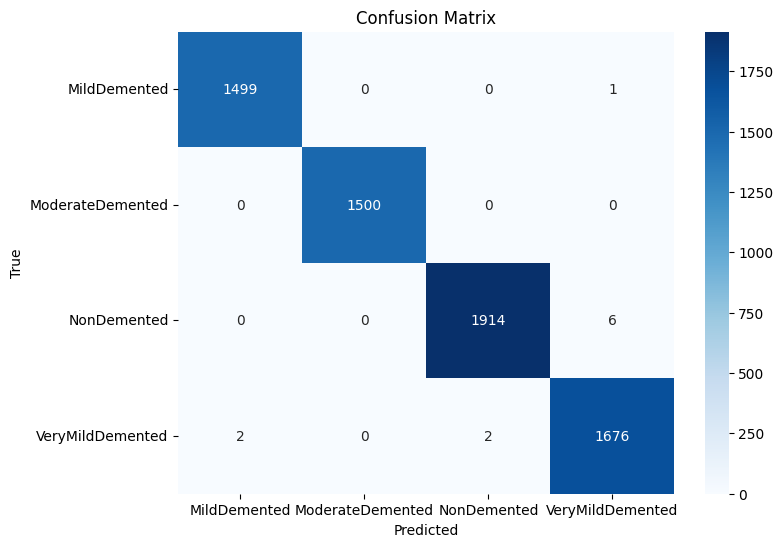

Confusion matrix saved to: /kaggle/working/results/densenet/confusion_matrix.png
Predictions saved to: /kaggle/working/results/densenet/test_predictions.csv
Per-class metrics saved to: /kaggle/working/results/densenet/per_class_metrics.csv


In [17]:
# Evaluate final model on test_gen (robust, saves results)
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Verify generator
try:
    assert not getattr(test_gen, 'shuffle', False), "Set test_gen.shuffle = False when creating generator"
except AssertionError as e:
    print("Warning:", e)

steps = len(test_gen)

# 2) Quick evaluate
loss, acc = model.evaluate(test_gen, steps=steps, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

# 3) Predictions for detailed metrics
pred_probs = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# True labels: prefer generator.classes if available
if hasattr(test_gen, 'classes'):
    y_true = test_gen.classes
else:
    # fallback: collect labels from generator
    y_true = []
    for X, y in test_gen:
        lab = y.numpy() if hasattr(y, 'numpy') else y
        y_true.extend(np.argmax(lab, axis=1))
    y_true = np.array(y_true)[:len(y_pred)]

# 4) Class names
if hasattr(test_gen, 'class_indices'):
    class_names = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda x: x[1])]
else:
    class_names = [f'class_{i}' for i in range(pred_probs.shape[1])]

# 5) Reports & confusion matrix
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
os.makedirs(config.RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix.png'), bbox_inches='tight', dpi=150)
plt.show()
plt.close()
print(f"Confusion matrix saved to: {os.path.join(config.RESULTS_DIR, 'confusion_matrix.png')}")

# 6) Save per-sample predictions
rows = []
filenames = getattr(test_gen, 'filenames', None)
if filenames and len(filenames) >= len(y_pred):
    for fn, yt, yp in zip(filenames[:len(y_pred)], y_true, y_pred):
        rows.append({'filename': fn, 'y_true': int(yt), 'y_pred': int(yp)})
else:
    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        rows.append({'index': i, 'y_true': int(yt), 'y_pred': int(yp)})

df = pd.DataFrame(rows)
out_csv = os.path.join(config.RESULTS_DIR, 'test_predictions.csv')
df.to_csv(out_csv, index=False)
print(f"Predictions saved to: {out_csv}")

# 7) Save per-class precision/recall/f1
p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average=None)
summary = pd.DataFrame({
    'class': class_names,
    'precision': p,
    'recall': r,
    'f1': f,
    'support': s
})
summary.to_csv(os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv'), index=False)
print(f"Per-class metrics saved to: {os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv')}")